In [3]:
from keras import backend as K
K.clear_session()

----

## 8.400 Latent spaces, GANs and VAEs

Create new images by sampling a latent image space

Currently the most popular and successful application of creative AI

Two techniques:

1. Variational autoencoders (VAEs)

2. Generative adverserial network (GANs)

----

## 8.410 Latent space sampling

The latent space is low dimensional

Each point in the space corresponds to a realistic image

A *generator (GAN) or decoder (VAE)* module realises the mapping from latent space to realistic images

The latent space can be sampled; new, never seen before, yet (hopefully) realistic, images are created

GANs and VAEs generate latent spaces in different ways

VAEs are good at generating structured latent spaces where specific directions encode meaningful data

GAN generate very realistic images but the latent space may not be so structured and is less useful for image editing

----

## 8.420 Concept vectors

Similar to embeddings.

Different directions encode interesting axes e.g. a 'smile' vector

If you have found a smile vector, you could project an image into the latent space, add a smile vector, and then decode.

Concept vectors exist for independent axes e.g. adding sunglasses, beards...

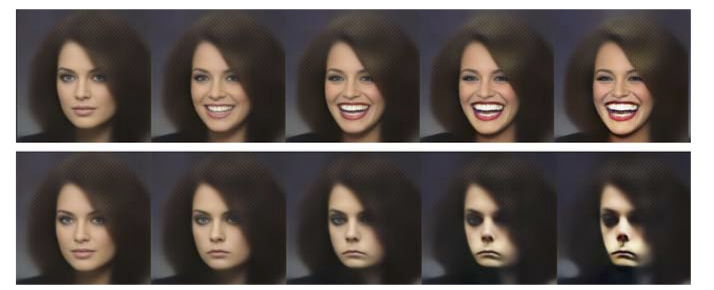

----

# 8.430 Variational autoencoders

A classic autoencoder maps an image to a low dimensional latent space - a kind of compression - and then decodes back to the original dimensionality

The autoecoder then learns to reconstruct the input from the decoded output


![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

But these classic spaces are not structured in a useful way

VAEs do not compress into a fixed code in the latent space, but find parameters (mean and std) of a probability distribution

The assumption is that the output image is the result of a statistical process and the randomness of this process should be taken into account during encoding and decoding

The randomness (stochasticity) improves robustness and forces the latent space to encode meaningful representations everywhere

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

##### How?

1. Encoder maps an input image to $\mu$ and $\sigma$.
2. Randomly sample: $z \sim N(\mu, \sigma^2)$ i.e. $z \sim \mu + \sigma N(0, 1)$.
3. A decoder module maps $z$ back to the original image space.



There are two loss functions
- reconstruction loss: forces the decoded samples to match the initial inputs
- regularisation loss: ensures well-formed latent spaces and minimal overfitting



The stochastic sampling means that slightly different latent vectors will be generated from the same source

The decoder is attempting to decode all the random latent vectors emanating from the same source to the same target (which is identical to the source!) 

=> neighbouring points in the latent space are decoded to the same image.



$z \sim N(\mu, \sigma^2)$

You can think of $z$ as a point in the latent space and $\sigma$ defining an area around this point

The regularisation loss ensures that the $z$'s are clustered together at the centre of the latent space



The $\sigma$ areas overlap so that and a continuous and structured representation is built.

New images are generated by decoding a selected point $z$ in the latent space

Notebook code is borrowed from the DLWP GitLab `tensorflow 2` repository

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part04_variational-autoencoders.ipynb

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [3]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

VAE training

In [7]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 106s 194ms/step - total_loss: 210.0910 - reconstruction_loss: 207.6422 - kl_loss: 2.4489
Epoch 2/30
547/547 [==============================] - 110s 201ms/step - total_loss: 176.1041 - reconstruction_loss: 172.4293 - kl_loss: 3.6747
Epoch 3/30
547/547 [==============================] - 123s 225ms/step - total_loss: 163.0408 - reconstruction_loss: 159.1703 - kl_loss: 3.8702
Epoch 4/30
547/547 [==============================] - 117s 214ms/step - total_loss: 158.5823 - reconstruction_loss: 154.6266 - kl_loss: 3.9557
Epoch 5/30
547/547 [==============================] - 114s 208ms/step - total_loss: 156.0207 - reconstruction_loss: 152.0117 - kl_loss: 4.0090
Epoch 6/30
547/547 [==============================] - 107s 196ms/step - total_loss: 154.3569 - reconstruction_loss: 150.3513 - kl_loss: 4.0056
Epoch 7/30
547/547 [==============================] - 114s 209ms/step - total_loss: 153.1869 - reconstruction_loss: 149.2002 - kl_loss: 3.9864

Sampling a grid of point from the 2D latent space and decoding to images

In [ ]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")

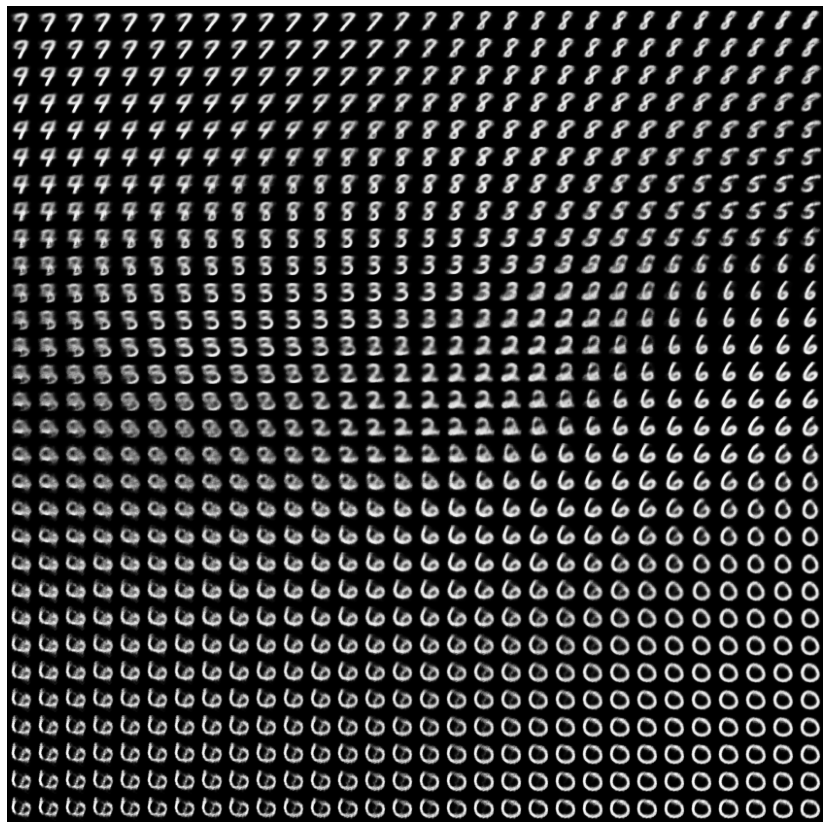

In [8]:
plt.imshow(figure, cmap="Greys_r")

----

## 8.440 Wrapping up

Image generation with deep learning: learned latent spaces capture statistical information about a dataset of images

Never-seen-before images are produced by sampling and decoding points from the latent space

There are two major tools to do this: VAEs and GANs



VAEs result in highly structured, continuous latent representations

They work well for image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on

VAEs also work nicely for latent-space-based animations e.g. a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way

GANs generate realistic single-frame images but may not induce latent spaces with solid structure and high continuity

To play further with image generation, try the Celeb Faces Attributes (CelebA) dataset

It’s a free-to-download image dataset containing more than 200,000 celebrity portraits. It’s great for experi- menting with concept vectors in particular—it definitely beats MNIST.

----